# Analysis of Cell Selectivity for DRD87 in NO

In [1]:
# Bring your packages onto the path
import os
import sys
sys.path.append(os.path.abspath(os.path.join("..", "..")))

import pandas as pd
import numpy as np
import seaborn as sns
from analysis import sig_proc
from analysis.graph_analysis_utils import NeuronNetwork
from analysis.analysis_utils import FeatureExtractor
from analysis.resampling import Resampler
from IPython.core.interactiveshell import InteractiveShell

In [2]:
%matplotlib inline
InteractiveShell.ast_node_interactivity = "all"

In [3]:
mouse_directory = os.path.join(os.path.expanduser("~"), "Hen_Lab/Mice/DRD87")

if not os.path.exists(mouse_directory):
    print("The mouse directory does not exist", file=sys.stderr)

file_num = 0
raw_files = list()
for dir_name, subdir_list, file_list in os.walk(mouse_directory):
    for file_name in file_list:
        if file_name.endswith(".csv"):
            print("{}. full path of: {} is: {}".format(file_num, file_name, os.path.join(dir_name, file_name)))
            file_num += 1
            raw_files.append(os.path.join(dir_name, file_name))

0. full path of: EPM_NO_OFT_POPP_cellreg_dict.csv is: /Users/saveliyyusufov/Hen_Lab/Mice/DRD87/EPM_NO_OFT_POPP_cellreg_dict.csv
1. full path of: behavior_drd87_POPP.csv is: /Users/saveliyyusufov/Hen_Lab/Mice/DRD87/behavior_drd87_POPP.csv
2. full path of: EPM_NO_OFT_POPP_centroids.csv is: /Users/saveliyyusufov/Hen_Lab/Mice/DRD87/EPM_NO_OFT_POPP_centroids.csv
3. full path of: D87_POPP_C_raw.csv is: /Users/saveliyyusufov/Hen_Lab/Mice/DRD87/D87_POPP_C_raw.csv
4. full path of: D87_OFT_C_raw.csv is: /Users/saveliyyusufov/Hen_Lab/Mice/DRD87/D87_OFT_C_raw.csv
5. full path of: Behavior_DRD87_NO.csv is: /Users/saveliyyusufov/Hen_Lab/Mice/DRD87/Behavior_DRD87_NO.csv
6. full path of: D87_NO_C_raw.csv is: /Users/saveliyyusufov/Hen_Lab/Mice/DRD87/D87_NO_C_raw.csv
7. full path of: Raw_EPM2_drd87.csv is: /Users/saveliyyusufov/Hen_Lab/Mice/DRD87/Raw_EPM2_drd87.csv
8. full path of: Behavior_DRD87_EPM.csv is: /Users/saveliyyusufov/Hen_Lab/Mice/DRD87/Behavior_DRD87_EPM.csv


### Import the csv of raw neuron signal data into a pandas DataFrame, and run the data through the Dombeck 2007 signal rocessing algorithm.

In [4]:
drd87_data = pd.read_csv(raw_files[6], header=None)
_, auc_dataframe, cell_transients_dataframe = sig_proc.detect_ca_transients_mossy(drd87_data, 2, 0.5, 0.2, 10)

drd87_behavior = pd.read_csv(raw_files[5])
drd87_behavior.drop(columns=["X center", "Y center", "Area", "Areachange", "Elongation", "Distance moved", "Velocity", "Result 1"], inplace=True)
drd87_behavior.columns = ["Trial Time", "Recording Time", "Arena_centerpoint", "Novel_Object_centerpoint", "Neutral_Zone_centerpoint"]

drd87_fe = FeatureExtractor(cell_transients_df=cell_transients_dataframe, auc_df=auc_dataframe, behavior_df=drd87_behavior)

/Users/saveliyyusufov/Hen_Lab/analysis/analysis_utils.py:26: Warning:

Row multiple to downsample behavior dataframe not specified. Behavior dataframe will be downsampled by a row multiple of 3



### We compute the actual $\hat{D}$ values for all of the neuron column vectors in DRD87's `neuron_concated_behavior` dataframe

In [5]:
no_real_diff_vals = drd87_fe.set_real_diff_df(drd87_fe.neuron_concated_behavior, drd87_fe.auc_df.columns, "Novel_Object_centerpoint", "Neutral_Zone_centerpoint")
no_real_diff_vals

/Users/saveliyyusufov/Hen_Lab/analysis/analysis_utils.py:106: Warning:

Frame rate wasn't specified, so frame rate will be set to 10



,neuron1,neuron2,neuron3,neuron4,neuron5,neuron6,neuron7,neuron8,neuron9,neuron10,...,neuron43,neuron44,neuron45,neuron46,neuron47,neuron48,neuron49,neuron50,neuron51,neuron52
D,-0.982822,1.89006,-4.61537,-6.23302,0.826767,2.46959,-2.97508,2.17559,-11.8144,0.669313,...,0.192681,1.96007,0.9887,-1.45949,-3.65233,-1.99966,-5.82677,-6.80028,-3.72449,2.22875


### Now, we construct the permutation distributions of the $\hat{D}$ values, for each neuron column vector, from its values in a large number of resamples. Immediately afterwards, we plot the distribution, for each neuron. 

In [6]:
resampled_df = Resampler.shuffle(10000, drd87_fe.neuron_concated_behavior, drd87_fe.auc_df.columns, "Novel_Object_centerpoint", "Neutral_Zone_centerpoint")

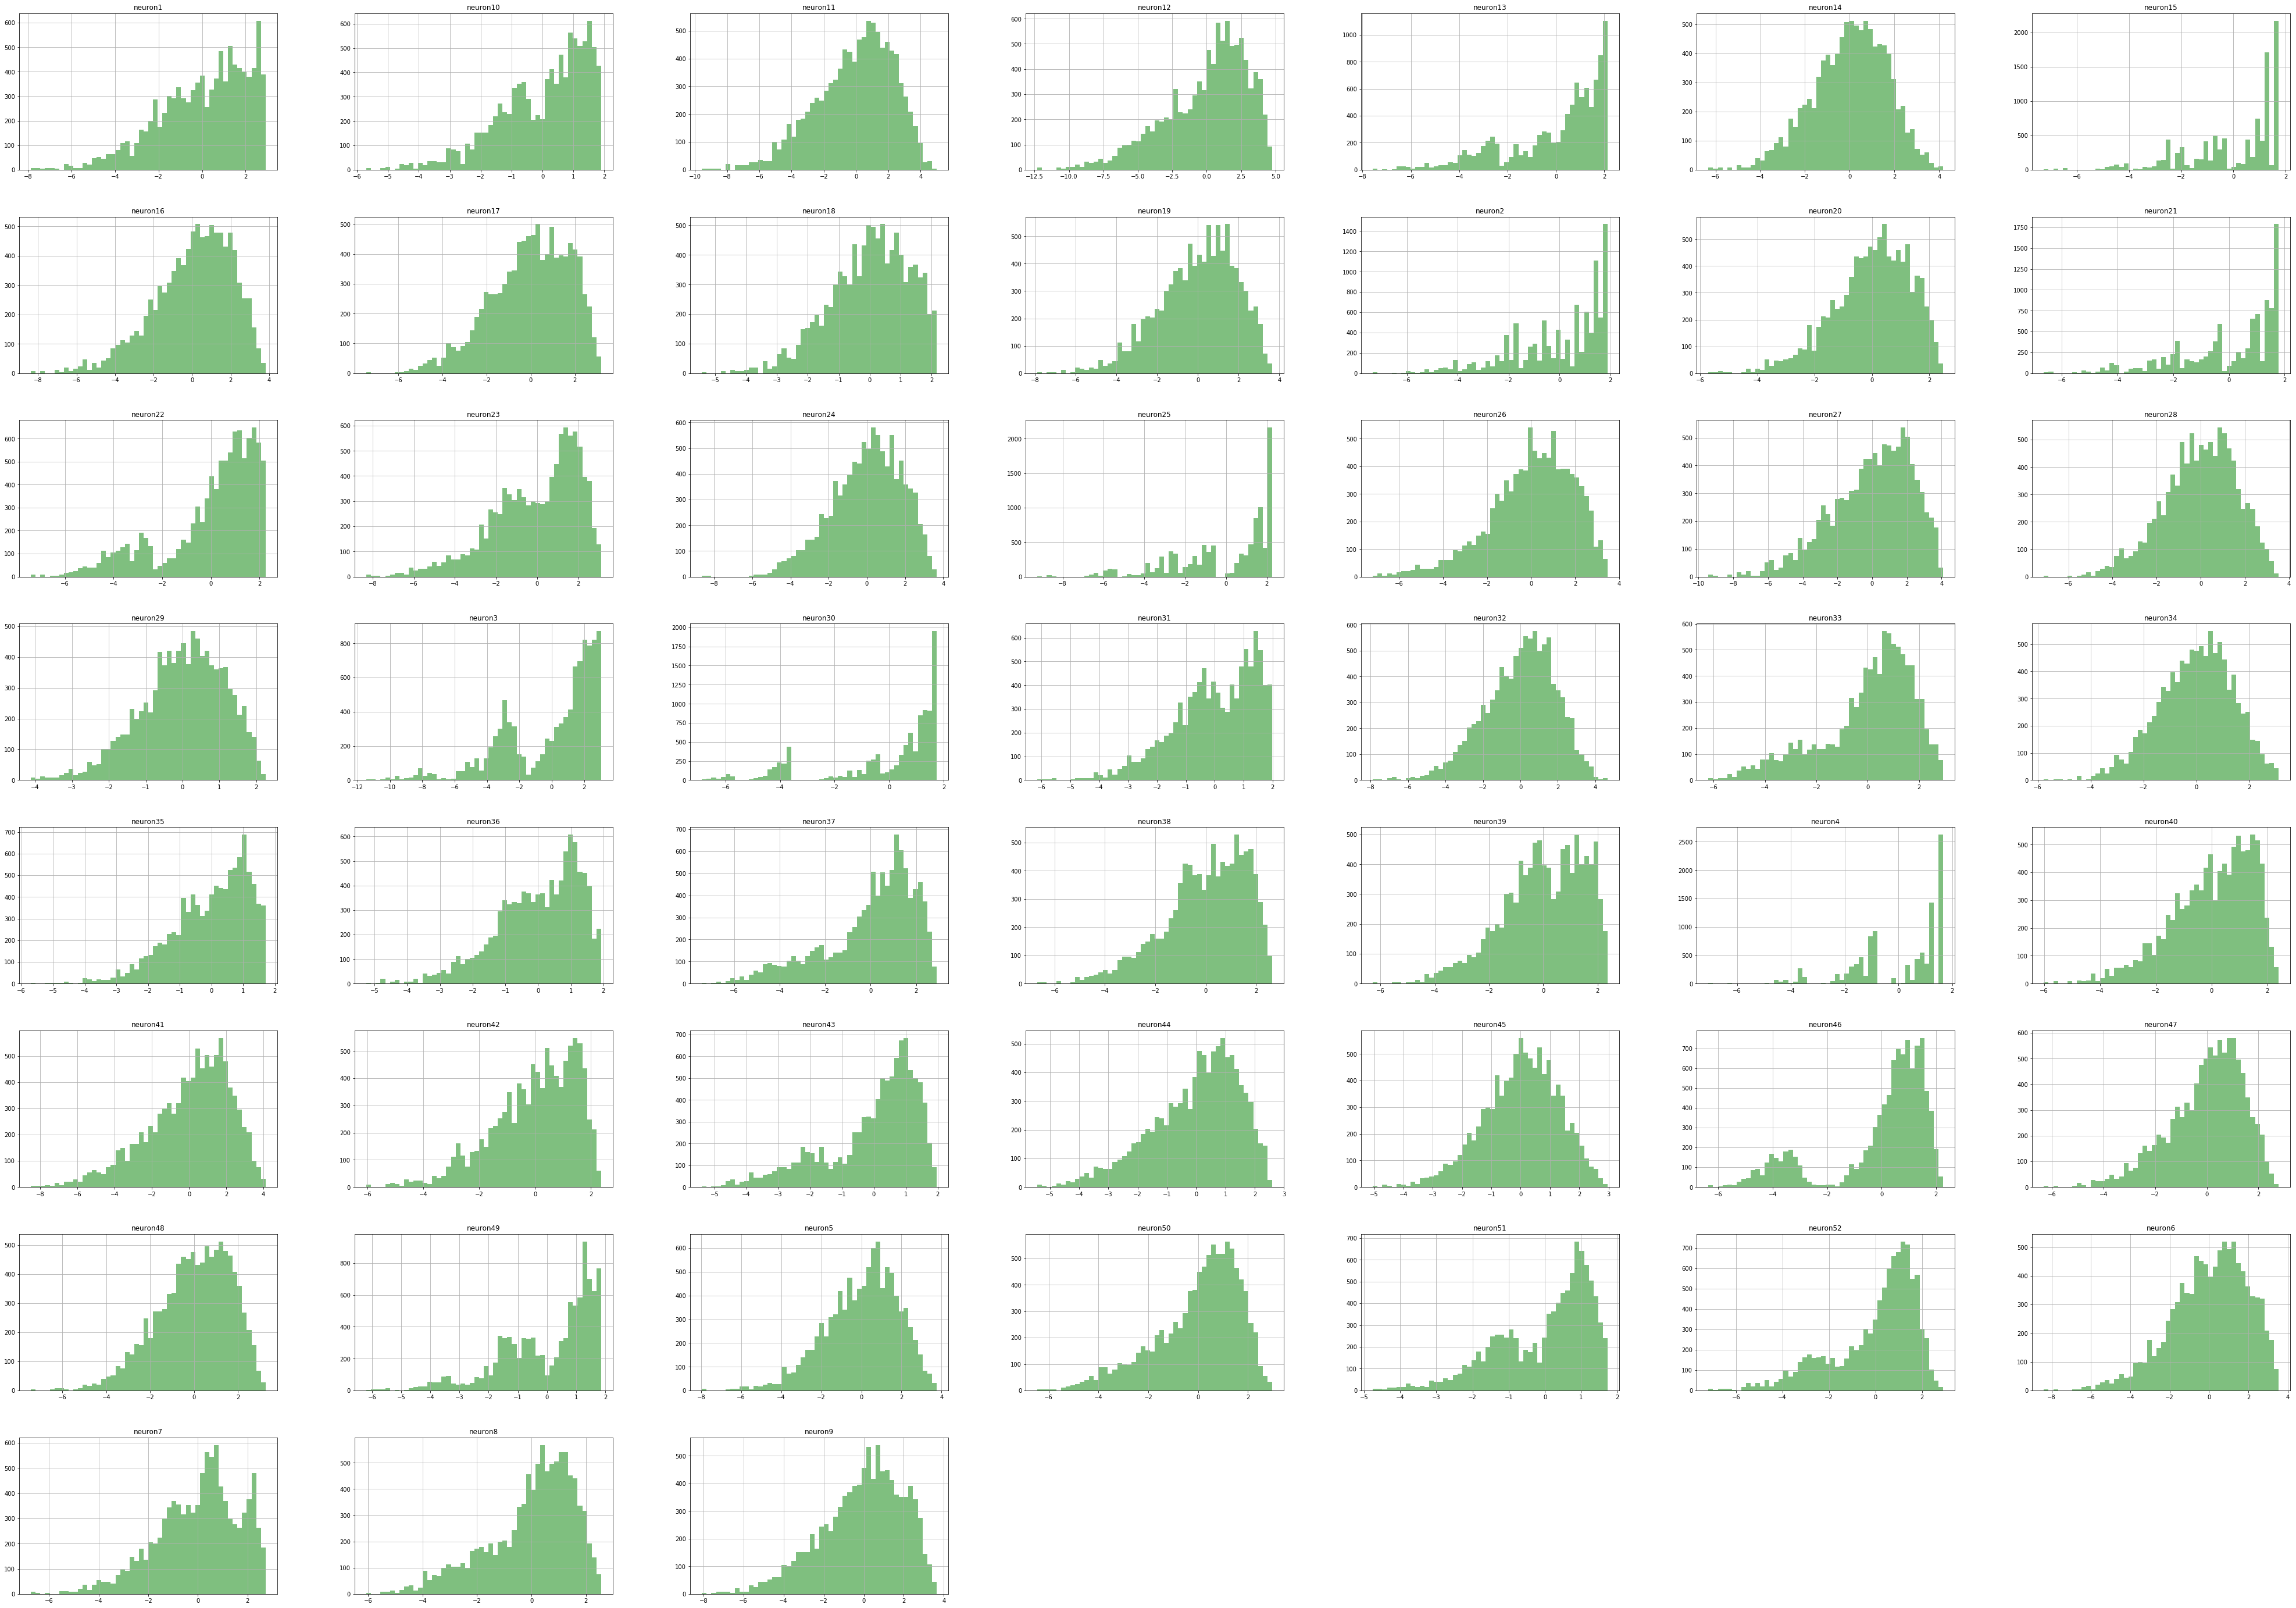

In [7]:
resampled_df.hist(alpha=0.5, color="green", bins=50, figsize=(70, 50));

### Now we compute: $$\sum_{i=1}^p \mathbb{1}(|\hat{D}_i| > |\hat{D}|)$$, for each neuron's permutation distribution in order to classify each neuron as *selective*, *not-selectice* or *unclassified*.
### Next, we perform a "deeper classification". Namely, we go through and classify each *selective* neuron with a $\hat{D} > 0$ as selective for $behavior_1$. Likewise, we go through and classify each *selective* neuron with a $\hat{D} < 0$ as selective for $behavior_2$.

In [8]:
def deep_classify(classified_neurons, real_diff_vals, *behaviors):
    deeper_classification = classified_neurons.copy()

    for neuron in deeper_classification:
        if real_diff_vals[neuron].values > 0:
            if deeper_classification[neuron] == "selective":
                deeper_classification[neuron] = behaviors[0]
        elif real_diff_vals[neuron].values < 0:
            if deeper_classification[neuron] == "selective":
                deeper_classification[neuron] = behaviors[1]
                
    return deeper_classification

In [9]:
no_classified_neurons = Resampler.non_normal_neuron_classifier(drd87_fe.auc_df, resampled_df, no_real_diff_vals, p_value=0.05, threshold=5)
no_selective_neurons = deep_classify(no_classified_neurons, no_real_diff_vals, "Novel_Object_centerpoint", "Neutral_Zone_centerpoint")
no_selective_neurons

{'neuron4': 'unclassified',
 'neuron1': 'not-selective',
 'neuron2': 'not-selective',
 'neuron3': 'not-selective',
 'neuron5': 'not-selective',
 'neuron6': 'not-selective',
 'neuron7': 'not-selective',
 'neuron8': 'not-selective',
 'neuron9': 'Neutral_Zone_centerpoint',
 'neuron10': 'not-selective',
 'neuron11': 'Neutral_Zone_centerpoint',
 'neuron12': 'not-selective',
 'neuron13': 'Neutral_Zone_centerpoint',
 'neuron14': 'Novel_Object_centerpoint',
 'neuron15': 'Neutral_Zone_centerpoint',
 'neuron16': 'not-selective',
 'neuron17': 'not-selective',
 'neuron18': 'Neutral_Zone_centerpoint',
 'neuron19': 'not-selective',
 'neuron20': 'not-selective',
 'neuron21': 'not-selective',
 'neuron22': 'not-selective',
 'neuron23': 'Neutral_Zone_centerpoint',
 'neuron24': 'Neutral_Zone_centerpoint',
 'neuron25': 'not-selective',
 'neuron26': 'not-selective',
 'neuron27': 'not-selective',
 'neuron28': 'not-selective',
 'neuron29': 'not-selective',
 'neuron30': 'not-selective',
 'neuron31': 'not-sele

In [10]:
novel_selective_count = 0
neutral_selective_count = 0
not_selective = 0
for neuron in no_selective_neurons:
    if no_selective_neurons[neuron] == "Novel_Object_centerpoint":
        novel_selective_count += 1
    elif no_selective_neurons[neuron] == "Neutral_Zone_centerpoint":
        neutral_selective_count += 1
    else:
        not_selective += 1
        
        
print("{} neurons were selective for Novel_Object_centerpoint".format(novel_selective_count))
print("{} neurons were selective for Neutral_Zone_centerpoint".format(neutral_selective_count))
print("{} neurons were not-selective".format(not_selective))

1 neurons were selective for Novel_Object_centerpoint
12 neurons were selective for Neutral_Zone_centerpoint
39 neurons were not-selective


In [11]:
import warnings 

def activity_by_neurons(concated_df, neuron_names, *behaviors, **kwargs):
    """Computes the neuron activity rates for given behaviors
    
    This function computes the rates for a given animal's activity and  
    neuron, given some set of behaviors.

    Args: 
        concated_df: DataFrame
        
            A concatenated pandas DataFrame of the neuron activity and 
            the corresponding behavior, for a given animal.
        
        neuron_names: list
        
            The names of the neurons whose rates are to be computed.
        
        behaviors: 
            
            The behaviors for which to compute the activity rates. 
        
        frame_rate: int, optional
        
            The framerate to multiply the activity rate by, default is 10.

    Returns: 
        activity_df: a pandas DataFrame of the neuron activity rates.
    """
    frame_rate = kwargs.get("frame_rate", None)
    if frame_rate is None:
        warnings.warn("You did not specify a frame rate, so a frame rate"
                      + " of 10 will be utilized in the computation", Warning)
        frame_rate = 10
        
    activity_df = pd.DataFrame(columns=behaviors)
    
    for behavior in behaviors:
        if behavior in concated_df.columns:
            activity_df.loc[:, behavior] = frame_rate * concated_df.loc[concated_df[behavior] != 0, neuron_names].mean()
        elif '&' in behavior:
            beh1 = behavior.split('&')[0]
            beh2 = behavior.split('&')[1]
            activity_df.loc[:, behavior] = frame_rate * concated_df.loc[(concated_df[beh1] != 0) & ((concated_df[beh2] != 0)), neuron_names].mean()
        elif '|' in behavior:
            beh1 = behavior.split('|')[0]
            beh2 = behavior.split('|')[1]
            activity_df.loc[:, behavior] = frame_rate * concated_df.loc[(concated_df[beh1] != 0) | ((concated_df[beh2] != 0)), neuron_names].mean()

    return activity_df

In [12]:
import plotly
import plotly.graph_objs as go

def plot_activity_rates(activity_rates_df, **kwargs):
    """Wrapper function for Plotly Bar Charts
        
        This function wraps the Plotly library Bar Chart plotting functionality
        in order to quickly and easily create a bar plot for 
    
    Args:
        activity_rates_df: DataFrame
        
            The pandas DataFrame with all the neuron activity means,
            for corresponding behaviors
            
        title: str, optional
        
            The title of the bar plot, to be displayed above the plot,
            default is "Title Goes Here".
        
        color: str, optional
            
            The color of the bar plot to be plotted, e.g., "rgb(10,10,10)",
            default is "rgb(10,10,200)".
    """
    x = [beh for beh in activity_rates_df.columns]
    y = [activity_rates_df[behavior].mean() for behavior in activity_rates_df.columns]

    title = kwargs.get("title", "Title Goes Here")
    color = kwargs.get("color", "rgb(10,10,200)")
    trace1 = go.Bar(
        x=x,
        y=y,
        text=y,
        marker=dict(
            color=color
        ),
        opacity=0.7
    )

    data = [trace1]
    layout = go.Layout(
        title=title,
    )
    fig = go.Figure(data=data, layout=layout)
    plotly.offline.iplot(fig)

In [13]:
def get_continuous_beh_dfs(feature_extractor, behavior, **kwargs):
    seconds = kwargs.get("seconds", 5)
    framerate = kwargs.get("framerate", 10)
    dataframes = list()
    
    continuous_beh = dict()
    for row in feature_extractor.neuron_concated_behavior.itertuples():
        if getattr(row, behavior) == 1:
            continuous_beh[row[0]] = 1
        else:
            if len(continuous_beh) >= seconds*framerate:

                # Note the start frame, and the end frame for when the animal entered the area.
                begin = list(continuous_beh.keys())[0]
                end = list(continuous_beh.keys())[len(list(continuous_beh.keys()))-1]

                dataframes.append(feature_extractor.neuron_concated_behavior.iloc[begin:end])

                continuous_beh.clear()
            else:
                continuous_beh.clear()
                
    return dataframes

In [14]:
def get_rates_for_cont_beh(feature_extractor, behavior, seconds):
    dataframes = get_continuous_beh_dfs(feature_extractor, behavior, seconds=seconds)
    
    rates = list()
    for df in dataframes:
        activity_rates_df = activity_by_neurons(df, feature_extractor.auc_df.columns, behavior)
        rates.append(activity_rates_df[behavior].mean())
        
    return rates, dataframes

In [15]:
def sort_rates_chronological(feature_extractor, open_arms_dataframes, closed_arms_dataframes, *behaviors):
    i = 0
    j = 0
    rates = list()
    markers_on = list()

    while i < len(open_arms_dataframes):
        if open_arms_dataframes[i].index.values[-1] < closed_arms_dataframes[j].index.values[-1]:
            activity_rates_df = activity_by_neurons(open_arms_dataframes[i], feature_extractor.auc_df.columns, behaviors[0])
            rates.append(activity_rates_df[behaviors[0]].mean())
            markers_on.append(len(rates)-1)
            i += 1
        else:
            activity_rates_df = activity_by_neurons(closed_arms_dataframes[j], feature_extractor.auc_df.columns, behaviors[1])
            rates.append(activity_rates_df[behaviors[1]].mean())
            j += 1
            
            if j == len(closed_arms_dataframes):
                break

    while j < len(closed_arms_dataframes):
        activity_rates_df = activity_by_neurons(closed_arms_dataframes[j], feature_extractor.auc_df.columns, behaviors[1])
        rates.append(activity_rates_df[behaviors[1]].mean())
        j += 1
        
    while i < len(open_arms_dataframes):
        activity_rates_df = activity_by_neurons(open_arms_dataframes[i], feature_extractor.auc_df.columns, behaviors[0])
        rates.append(activity_rates_df[behaviors[0]].mean())
        markers_on.append(len(rates)-1)
        i += 1
    
    return rates, markers_on

In [16]:
import matplotlib.pyplot as plt

def quick_plot(y_axis, figsize, color="blue", title="Title Goes Here", markevery=None):
    plt.figure(figsize=figsize)
    plt.plot(y_axis, color=color, marker='o', linestyle="solid", linewidth=1, markersize=7, markevery=markevery)
    plt.xlabel("Entry")
    plt.ylabel("Rate")
    plt.title(title)
    plt.grid(True)
    plt.show();

/anaconda3/envs/henlabenv/lib/python3.6/site-packages/ipykernel_launcher.py:33: Warning:

You did not specify a frame rate, so a frame rate of 10 will be utilized in the computation



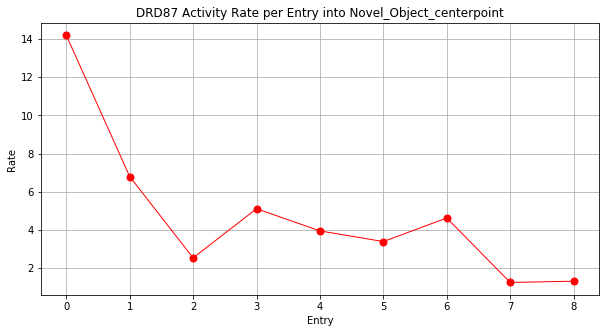

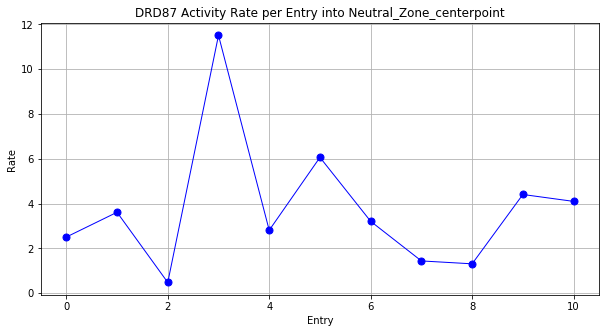

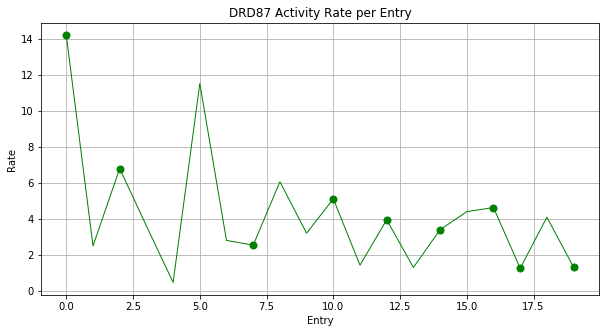

In [17]:
drd87_novel_rates, drd87_novel_dataframes = get_rates_for_cont_beh(drd87_fe, "Novel_Object_centerpoint", 2)
drd87_neutral_rates, drd87_neutral_dataframes = get_rates_for_cont_beh(drd87_fe, "Neutral_Zone_centerpoint", 2)

quick_plot(drd87_novel_rates, (10, 5), color="red", title="DRD87 Activity Rate per Entry into Novel_Object_centerpoint")
quick_plot(drd87_neutral_rates, (10, 5), color="blue", title="DRD87 Activity Rate per Entry into Neutral_Zone_centerpoint")

drd87_all_rates, drd87_markers_on = sort_rates_chronological(drd87_fe, drd87_novel_dataframes, drd87_neutral_dataframes, "Novel_Object_centerpoint", "Neutral_Zone_centerpoint")
quick_plot(drd87_all_rates, (10, 5), color="green", title="DRD87 Activity Rate per Entry", markevery=drd87_markers_on)